# 15 minutes to QCoDeS

This short introduction is aimed mainly for beginners. Before you start with your first code using QCoDeS, make sure you have properly set up the Python environment for QCoDeS as explained in [this  document](http://qcodes.github.io/Qcodes/start/index.html#installation). 

## Introduction 

An experimental setup comprises of many instruments. We call an experimental setup as "station". A station is connected to many instruments or devices. QCoDeS provides a way to interact with all these instruments to help users 
the measurements and store the data in a database. To interact (read, write, trigger, etc) with the instruments, we have created a [library of drivers](http://qcodes.github.io/Qcodes/api/generated/qcodes.instrument_drivers.html) for commonly used ones. These drivers implement the most needed functionalities of the instruments. 

An "Instrument" can perform many functions. For example, on an oscilloscope instrument, we first set a correct trigger level and other parameters and then obtain a trace. In QCoDeS lingo, we call "trigger_level" and "trace" as `parameter` of this `instrument`. An instrument at any moment will have many such parameters which together define the state of the instrument, hence a parameter can be thought of as a state variable of the instrument. QCoDeS provides a method to set values of these parameters (set trigger level) and get the values from them (obtain a trace). By this way, we can interact with all the needed parameters of an instrument and are ready to set up a measurement. 

QCoDeS has a similar programmatic structure, as well. QCoDeS structure comprises of a `Station` class which is a bucket of objects from `Instrument` class containing many objects from `Parameter` class. The value of these parameters are set and measured during a measurement. The `Measurement` class provides a context manager for registering the parameters and providing a link between different parameters. The measured data is stored in a database.

Here, we will briefly discuss how you can set up your own experiment with the help of QCoDeS. 

![SchematicOverviewQcodes](files/Schematic_Overview_Qcodes.png)



## Imports

If you are using QCoDeS as your main data acquisition framework, a typical Python script at your disposal may look like:

In [1]:
%matplotlib inline
import os
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
import qcodes as qc
from qcodes import (
    Measurement,
    experiments,
    initialise_database,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_experiment,
    load_last_experiment,
    load_or_create_experiment,
    new_experiment,
)
from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement

We strongly recommend not to import unused packages to increase readability of your code.

## Logging 

In every measurement session, it is highly recommended to have QCoDeS logging turned on. This will allow you to have all the logs in case troubleshooting is required. To enable logging, we can either add the following single line of code at the beginnig of our scripts after the imports:

In [2]:
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/210322-2367-qcodes.log


or we can configure qcodes to automatically start logging on every import of qcodes, by running the following code once. (This will persist the current configuration in `~\qcodesrc.json`)

In [3]:
from qcodes import config
config.logger.start_logging_on_import = 'always'
config.save_to_home()

You can find the log files at ".qcodes" directory, typically located at your home folder (e.g., see the corresponding path to the "Filename" key above). This path contains two log files: 
 - command_history.log: contains the commands executed. 
 
 And in this particular case
 - 191113-13960-qcodes.log: contains python logging information. The file is named as 
 \[date (YYMMDD)\]-\[process id\]-\[qcodes\].log. The display message from `start_all_logging()` function shows that the `Qcodes Logfile` is saved  at `C:\Users\a-halakh\.qcodes\logs\191113-13960-qcodes.log`

## Station creation  

A station is a collection of all the instruments and devices present in your experiment. As mentioned earlier, it can be thought of as a bucket where you can add your `instruments`, `parameters` and other `components`. Each of these terms has a definite meaning in QCoDeS and shall be explained in later sections. Once a station is properly configured, you can use its instances to access these components. We refer to tutorial on [Station](http://qcodes.github.io/Qcodes/examples/Station.html) for more details.

We start with instantiating a station class which at the moment does not comprise of any instruments or parameters.

In [4]:
station = qc.Station()

### Snapshot

We can look at all the instruments and the parameters inside this station bucket using `snapshot` method. Since at the moment we have not added anything to our station, the snapshot will contain the names of the keys with no values: 

In [5]:
station.snapshot()

{'instruments': {}, 'parameters': {}, 'components': {}, 'config': None}

The [snapshot](http://qcodes.github.io/Qcodes/examples/DataSet/Working%20with%20snapshots.html) of the station is categorized as the dictionary of all the `instruments`,` parameters`, `components` and list of `default_measurement`. Once you have populated your station you may want to look at the snapshot again.

## Instrument

`Instrument` class in Qcodes is responsible for holding connections to hardware, creating a parameter or method for each piece of functionality of the instrument. For more information on instrument class we refer to the [detailed description here](http://qcodes.github.io/Qcodes/user/intro.html#instrument)  or the corresponding [api documentation](http://qcodes.github.io/Qcodes/api/instrument/index.html). 

Let us, now, create two dummy instruments and associate two parameters for each of them:

In [6]:
# A dummy instrument dac with two parameters ch1 and ch2
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])

# A dummy instrument that generates some real looking output depending
# on the values set on the setter_instr, in this case the dac
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

Aside from the bare ``snapshot``, which returns a Python dictionary, a more readable form can be returned via:

In [7]:
dac.print_readable_snapshot()

dac:
	parameter value
--------------------------------------------------------------------------------
IDN :	None 
ch1 :	0 (V)
ch2 :	0 (V)


In [8]:
dmm.print_readable_snapshot()

dmm:
	parameter value
--------------------------------------------------------------------------------
IDN :	None 
v1  :	0 (V)
v2  :	0 (V)


### Add instruments into station 

Every instrument that you are working with during an experiment should be added to the instance of the `Station` class. Here, we add the `dac` and `dmm` instruments by using ``add_component`` method: 

#### Add components

In [9]:
station.add_component(dac)
station.add_component(dmm)

'dmm'

#### Remove component 

We use the method `remove_component` to remove a component from the station. For example you can remove `dac` as follows:  


In [10]:
station.remove_component('dac')

<DummyInstrument: dac>

In [11]:
station.components

{'dmm': <DummyInstrumentWithMeasurement: dmm>}

Let us add the `dac` instrument back: 

In [12]:
station.add_component(dac)

'dac'

#### Station snapshot

As there are two instruments added to the station object, the snapshot will include all the properties associated with them:

In [13]:
station.snapshot()

{'instruments': {'dmm': {'functions': {},
   'submodules': {},
   '__class__': 'qcodes.tests.instrument_mocks.DummyInstrumentWithMeasurement',
   'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
     'full_name': 'dmm_IDN',
     'value': {'vendor': None,
      'model': 'dmm',
      'serial': None,
      'firmware': None},
     'raw_value': {'vendor': None,
      'model': 'dmm',
      'serial': None,
      'firmware': None},
     'ts': '2021-03-22 07:52:43',
     'post_delay': 0,
     'instrument': 'qcodes.tests.instrument_mocks.DummyInstrumentWithMeasurement',
     'instrument_name': 'dmm',
     'name': 'IDN',
     'unit': '',
     'vals': '<Anything>',
     'label': 'IDN',
     'inter_delay': 0},
    'v1': {'__class__': 'qcodes.tests.instrument_mocks.DmmExponentialParameter',
     'full_name': 'dmm_v1',
     'value': 4.90456056913143,
     'raw_value': 4.90456056913143,
     'ts': '2021-03-22 07:52:43',
     'post_delay': 0,
     'instrument': 'qcodes.tests

#### Station Configurator

The instantiation of the instruments, that is, setting up the proper initial values of the corresponding parameters and similar pre-specifications of a measurement constitutes the initialization portion of the code. In general, this portion can be quite long and tedious to maintain. These (and more) concerns can be solved by a YAML configuration file of the `Station` object. We refer to the notebook on [station](http://qcodes.github.io/Qcodes/examples/Station.html#Default-Station) for more details.

## Parameter

A QCoDeS `Parameter` has the property that it is settable, gettable or both. Let us clarify this with an example of a real instrument, say an oscilloscope. An oscilloscope contains settings such as trigger mode, trigger level, source etc. Most of these settings can be set to a particular value in the instrument. For example, trigger mode can be set to 'edge' mode and trigger level to some floating number. Hence, these parameters are called settable. Similarly, the parameters that we are able to retrieve the values currently associated with them are called gettable. In this example notebook, we have a 'dac' instrument with 'ch1' and 'ch2' are added as its `Parameter`s. Similarly, we have a 'dmm' instrument with 'v1' and 'v2' are added as its `Parameter`s. We also note that, apart from the trivial use of `Parameter` as the standard parameter of the instrument, it can be used as a common variable to utilize storing/retrieving data. Furthermore, it can be used as a subclass in more complex design cases.

QCoDeS provides following parameter classes built in: 

   - `Parameter` : Represents a single value at a given time. Example: voltage. 
   - `ParameterWithSetpoints`: Represents an array of values of all the same type that are returned all at once. Example: voltage vs time waveform . We refer to the [notebook](http://qcodes.github.io/Qcodes/examples/Parameters/Simple-Example-of-ParameterWithSetpoints.html) in which more detailed examples concerning the use cases of this parameter can be found.
   - `DelegateParameter`: It is intended for proxy-ing other parameters. You can use different label, unit, etc in the delegated parameter as compared to the source parameter.
   - `MultiParameter`: Represents a collection of values with different meanings and possibly different dimensions. Example: I and Q, or I vs time and Q vs time.

Most of the times you can use these classes directly and use the `get`, `set` functions to get or set the values to those parameters. But sometimes it may be useful to subclass the above classes, in that case you should define `get_raw` and `set_raw` methods rather then `get` or `set` methods. The `get_raw`, `set_raw` method is automatically wrapped to provide a `get`, `set` method on the parameter instance. Overwriting get in subclass of above parameters or the `_BaseParameter` is not allowed and will throw a runtime error. 

To understand more about parameters consult the [notebook on Parameter](http://qcodes.github.io/Qcodes/examples/index.html#parameters) for more details. 

In most cases, a settable parameter accepts its value as a function argument. Let us set the a value of 1.1 for the 'ch1' parameter of the 'dac' instrument:

In [14]:
dac.ch1(1.1)

Similarly, we ask the current value of a gettable parameter with a simple function call. For example, the output voltage of dmm can be read via

In [15]:
dmm.v1()

4.1113154136998205

Further information can be found in the [user guide](http://qcodes.github.io/Qcodes/user/intro.html#parameter) or [api documentation](http://qcodes.github.io/Qcodes/api/parameters/index.html) of parameter. 

## Initialise database and experiment

Before starting a measurement, we first initialise a database. The location of the database is specified by the configuration object of the QCoDeS installation. The database is created with the latest supported version complying with the QCoDeS version that is currently under use. If a database already exists but an upgrade has been done to the QCoDeS, then that database can continue to be used and it is going to be upgraded to the latest version automatically at first connection.

The initialisation of the database is achieved via:

In [16]:
initialise_database()

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 796.49it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 572.13it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 355.72it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 665.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 881.34it/s]

Alternatively, if you already have a QCoDeS database which you would like to use for your measurement, say at ``~/myData.db``, it is sufficient to use

In [17]:
initialise_or_create_database_at("~/myData.db")

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 690.76it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 451.10it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 299.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 608.84it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 1075.19it/s]

Note that it is user's responsibility to provide the correct absolute path for the existing database. The notation of the path may differ with respect to the operating system. The method ``initialise_or_create_database_at`` makes sure that your QCoDeS session is connected to the referred database. If the database file does not exist, it will be initiated at the provided path.

### Current location of database

By default, QCoDeS initialises an empty database to your home directory:

In [18]:
qc.config.core.db_location

'~/myData.db'

### Change location of database

In case you would like to change the location of the database, for example, to the current working directory, it is sufficient to assign the new path as the value of the corresponding key ``db_location``:

In [19]:
cwd = os.getcwd()
qc.config["core"]["db_location"] = os.path.join(cwd, 'testing.db')

### Load or create experiment

After initialising the database we create the `Experiment` object. This object contains the name of the experiment and the sample, and the path of the database. You can  use `load_or_create_experiment` to find and return an experiment with the given experiment and sample name if it already exists, or create one if not found.

In [20]:
exp = load_or_create_experiment(experiment_name='dataset_context_manager',
                                sample_name="no sample1")

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 373.99it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 492.64it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 355.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 799.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 491.83it/s]

The methods shown above to load or create the experiment is the most versatile one. However for specific cases the following alternative methods can be used to create or load experiments:

In [21]:
# load_experiment_by_name(experiment_name='dataset_context_manager',sample_name="no sample")
# load_last_experiment()
# load_experiment(1)
# new_experiment(experiment_name='dataset_context_manager',sample_name="no sample")

## Measurement

Qcodes `Measurement` module provides a context manager for registering parameters to measure and store results. The measurement is first linked to the correct experiment and to the station by passing them as arguments. If no arguments are given, the latest experiment and station are taken as defaults. 

QCoDeS is capable of storing relations between the parameters, i.e., which parameter is independent and which parameter depends on another one. This capability is later used to make useful plots, where the knowledge of interdependencies is used to define the corresponding variables for the coordinate axes. The required (mandatory) parameters in the measurement are first registered. If there is an interdependency between any given two or more parameters, the independent one is declared as a 'setpoint'. In our example, ``dac.ch1`` is the independent parameter and ``dmm.v1`` is the dependent parameter whose setpoint is ``dac.ch1``.

In [22]:
meas = Measurement(exp=exp, station=station)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone

meas.write_period = 2 

with meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 1. 


The ``meas.run()`` returns a context manager for the experiment run. Entering the context returns the ``DataSaver`` object to the `datasaver` variable. The ``DataSaver`` class handles the saving of data to the database using the method ``add_result``. The ``add_result`` method validates the sizes of all the data points and store them intermittently into a private variable. Within every write-period of the measurement, the data of the private variable is flushed to the database.

``meas.write_period`` is used to define the periods after which the data is committed to the database. We do not commit individual datapoints during measurement to the database but only after some amount of data is collected in stipulated time period (in this case for 2 seconds). The default value of write_period is 5 seconds.  

## Data exploration

### List all the experiments in the database 

The list of experiments that are stored in the database can be called back as follows:

In [23]:
experiments()

[dataset_context_manager#no sample1#1@/home/runner/work/Qcodes/Qcodes/docs/examples/testing.db
 ---------------------------------------------------------------------------------------------
 1-results-1-dac_ch1,dmm_v1-10]

While our example database contains only few experiments, in reality the database will contain several experiments containing many datasets. Seldom, you would like to load a dataset from a particular experiment for further analysis. Here we shall explore different ways to find and retrieve already measured dataset from the database.

### List all the datasets in the database

Let us now retrieve the datasets stored within the current experiment via:

In [24]:
exp.data_sets()

[results #1@/home/runner/work/Qcodes/Qcodes/docs/examples/testing.db
 -------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric]

### Load the data set using one or more specifications

The method ``load_by_run_spec`` can be used to load a run with given specifications such as 'experiment name' and 'sample name':

In [25]:
dataset = load_by_run_spec(experiment_name='dataset_context_manager', captured_run_id=1)

While the arguments are optional, the function call will raise an error if more than one run matching the supplied specifications is found. If such an error occurs, the traceback will contain the specifications of the runs, as well. Further information concerning 'Uniquely identifying and loading runs' can be found in [this example notebook](DataSet/Extracting-runs-from-one-DB-file-to-another.ipynb#Uniquely-identifying-and-loading-runs).

For more information on the `DataSet` object that `load_by_run_spec` returned, refer to [DataSet class walkthrough article](DataSet/DataSet-class-walkthrough.ipynb).

### Plot dataset 

We arrived at a point where we can visualize our data. To this end, we use the ``plot_dataset`` method with ``dataset`` as its argument:

([<AxesSubplot:title={'center':'Run #1, Experiment dataset_context_manager (no sample1)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

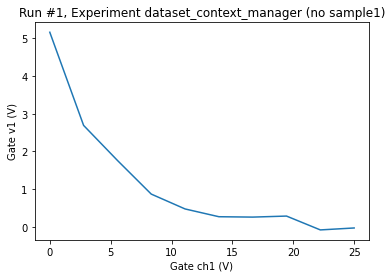

In [26]:
plot_dataset(dataset)

For more detailed examples of plotting QCoDeS datasets, refer to the following articles:

- [Offline plotting tutorial](DataSet/Offline%20Plotting%20Tutorial.ipynb)
- [Offline plotting with categorical data](DataSet/Offline%20plotting%20with%20categorical%20data.ipynb)
- [Offline plotting with complex data](DataSet/Offline%20plotting%20with%20complex%20data.ipynb)

### Get data of specific parameter of a dataset

If you are interested in numerical values of a particular parameter within a given dataset, the corresponding data can be retrieved by using `get_parameter_data` method:

In [27]:
dataset.get_parameter_data('dac_ch1')

{'dac_ch1': {'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [28]:
dataset.get_parameter_data('dmm_v1')

{'dmm_v1': {'dmm_v1': array([ 5.16494442,  2.691795  ,  1.76219198,  0.86857982,  0.4741692 ,
          0.26781536,  0.25777612,  0.28501459, -0.08245225, -0.03087338]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

We refer reader to [exporting data section of the performing measurements using qcodes parameters and dataset](DataSet/Performing-measurements-using-qcodes-parameters-and-dataset.ipynb#Accessing-and-exporting-the-measured-data) and [Accessing data in DataSet notebook](DataSet/Accessing-data-in-DataSet.ipynb) for further information on `get_parameter_data` method.

### Export data to pandas dataframe

If desired, any data stored within a QCoDeS database can also be exported as pandas dataframes. This can be achieved via:

In [29]:
df = dataset.to_pandas_dataframe_dict()['dmm_v1']
df.head()

,dmm_v1
dac_ch1,
0.000000,5.164944
2.777778,2.691795
5.555556,1.762192
8.333333,0.868580
11.111111,0.474169


### Export data to xarray

It's also possible to export data stored within a QCoDeS database to an `xarray.DataArray`. This can be achieved via:

In [30]:
xarray = dataset.to_xarray_dataarray_dict()['dmm_v1']
xarray.head()

<xarray.DataArray 'dmm_v1' (dac_ch1: 5)>
array([5.16494442, 2.691795  , 1.76219198, 0.86857982, 0.4741692 ])
Coordinates:
  * dac_ch1  (dac_ch1) float64 0.0 2.778 5.556 8.333 11.11
Attributes:
    name:           dmm_v1
    paramtype:      numeric
    label:          Gate v1
    unit:           V
    inferred_from:  []
    depends_on:     ['dac_ch1']

We refer to [example notebook on working with pandas](DataSet/Working-With-Pandas-and-XArray.ipynb) and [Accessing data in DataSet notebook](DataSet/Accessing-data-in-DataSet.ipynb) for further information.

### Explore the data using an interactive widget

Experiments widget presents the most important information at a glance, has buttons to plot the dataset and easily explore a snapshot, enabled users to add a note to a dataset.

It is only available in the Jupyter notebook because it uses [`ipywidgets`](https://ipywidgets.readthedocs.io/) to display an interactive elements.

Use it in the following ways:
```python
# import it first
from qcodes.interactive_widget import experiments_widget

# and then just run it
experiments_widget()  

# you can pass a specific database path
experiments_widget(db="path_of_db.db")

# you can also pass a specific list of DataSets:
# say, you're only interested in datasets of a particular experiment
experiments = qcodes.experiments()
data_sets = experiments[2].data_sets()
experiments_widget(data_sets=data_sets)

# you can change the sorting of the datasets
# by passing None, "run_id", "timestamp" as sort_by argument:
experiments_widget(sort_by="timestamp")
```

Here's a short video that summarizes the looks and the features:

![video demo about experiments widget should show here](../_static/experiments_widget.webp)

## Things to remember

### QCoDeS configuration  

QCoDeS uses a JSON based configuration system. It is shipped with a default configuration. The default config file should not be overwritten. If you have any modifications, you should save the updated config file on your home directory or in the current working directory of your script/notebook. The QCoDeS config system first looks in the current directory for a config file and then in the home directory for one and only then - if no config files are found - it falls back to using the default one. The default config is located in `qcodes.config`. To know how to change and save the config please refer to the [documentation on config](http://qcodes.github.io/Qcodes/user/configuration.html?).

### QCoDeS instrument drivers

We support and provide drivers for most of the instruments currently in use at the Microsoft stations. However, if more functionalities than the ones which are currently supported by drivers are required, one may update the driver or request the features form QCoDeS team. You are more than welcome to contribute and if you would like to have a quick overview on how to write instrument drivers, please refer to the [example notebooks on writing drivers](http://qcodes.github.io/Qcodes/examples/index.html#writing-drivers).

### QCoDeS measurements live plotting with Plottr

Plottr supports and is recommended for QCoDeS measurements live plotting. [How to use plottr with QCoDeS for live plotting](plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.ipynb) notebook contains more information.